# Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
from load_models import *
from loader import *
from syngem_utils import *

In [3]:
torch.manual_seed(42)
np.random.seed(42)

# Load models with 50 % sparsity

In [4]:
gem_model_50_21 = load_gemini_model("Resnet20", "50", "21")
gem_model_50_42 = load_gemini_model("Resnet20", "50", "42")
gem_model_50_63 = load_gemini_model("Resnet20", "50", "63")

In [43]:
syn_model_50_21 = load_synflow_model("Resnet20", "50", "21")
syn_model_50_42 = load_synflow_model("Resnet20", "50", "42")
syn_model_50_63 = load_synflow_model("Resnet20", "50", "63")

In [6]:
#rnd_model_50_21 = load_random_fc_sparsity_50_seed_21()
#rnd_model_50_42 = load_random_fc_sparsity_50_seed_42()
#rnd_model_50_63 = load_random_fc_sparsity_50_seed_63()

# Structural Analysis

### Get sparsities

In [44]:
sprse_gem_50_21 = check_sparsity(gem_model_50_21, single = True)
sprse_gem_50_42 = check_sparsity(gem_model_50_42, single = True)
sprse_gem_50_63 = check_sparsity(gem_model_50_63, single = True)

In [45]:
sprse_syn_50_21 = check_sparsity(syn_model_50_21, single = True)
sprse_syn_50_42 = check_sparsity(syn_model_50_42, single = True)
sprse_syn_50_63 = check_sparsity(syn_model_50_63, single = True)

In [13]:
#sprse_rnd_50_21 = check_sparsity(rnd_model_50_21, single = True)
#sprse_rnd_50_42 = check_sparsity(rnd_model_50_42, single = True)
#sprse_rnd_50_63 = check_sparsity(rnd_model_50_63, single = True)

### Sparsity tables

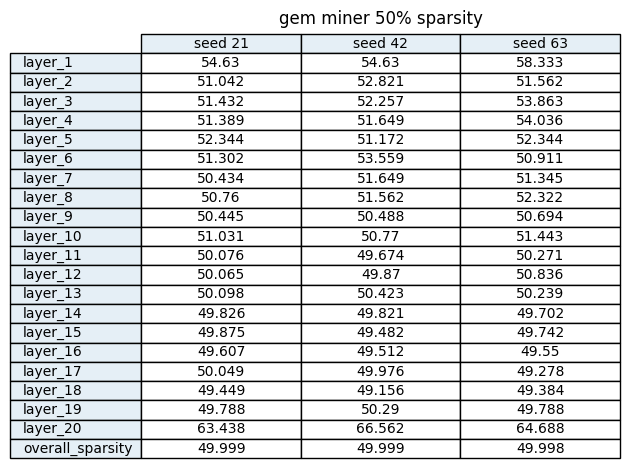

In [46]:
make_table(sprse_gem_50_21, sprse_gem_50_42, sprse_gem_50_63, "gem miner 50% sparsity")

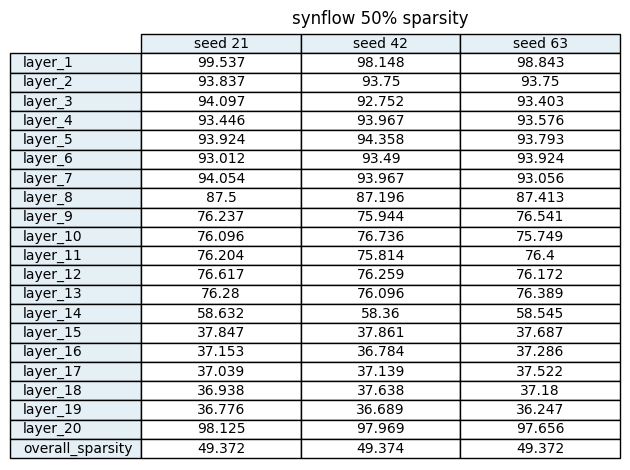

In [47]:
make_table(sprse_syn_50_21, sprse_syn_50_42, sprse_syn_50_63, "synflow 50% sparsity")

In [16]:
#make_table(sprse_rnd_50_21, sprse_rnd_50_42, sprse_rnd_50_63, "random 50% sparsity")

### Plot sparsities

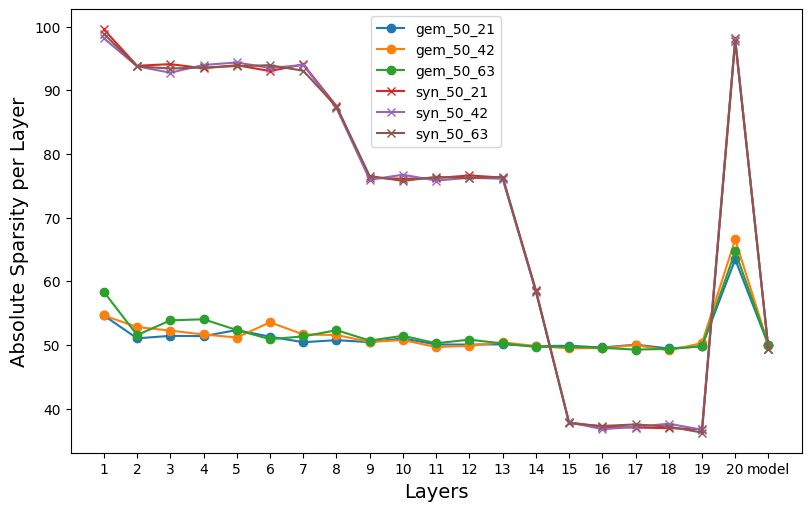

In [48]:
x_axis = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, "model"]

fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')

ax.plot(x_axis,list(sprse_gem_50_21.values()), label='gem_50_21', marker='o')
ax.plot(x_axis,list(sprse_gem_50_42.values()), label='gem_50_42', marker='o')
ax.plot(x_axis,list(sprse_gem_50_63.values()), label='gem_50_63', marker='o')

ax.plot(x_axis,list(sprse_syn_50_21.values()), label='syn_50_21', marker='x')
ax.plot(x_axis,list(sprse_syn_50_42.values()), label='syn_50_42', marker='x')
ax.plot(x_axis,list(sprse_syn_50_63.values()), label='syn_50_63', marker='x')

#ax.plot(x_axis,list(sprse_rnd_50_21.values()), label='rnd_50_21', marker='.')
#ax.plot(x_axis,list(sprse_rnd_50_42.values()), label='rnd_50_42', marker='.')
#ax.plot(x_axis,list(sprse_rnd_50_63.values()), label='rnd_50_63', marker='.')

ax.set_xlabel("Layers", fontsize=14)
ax.set_ylabel("Absolute Sparsity per Layer", fontsize=14)

ax.legend()
plt.show()

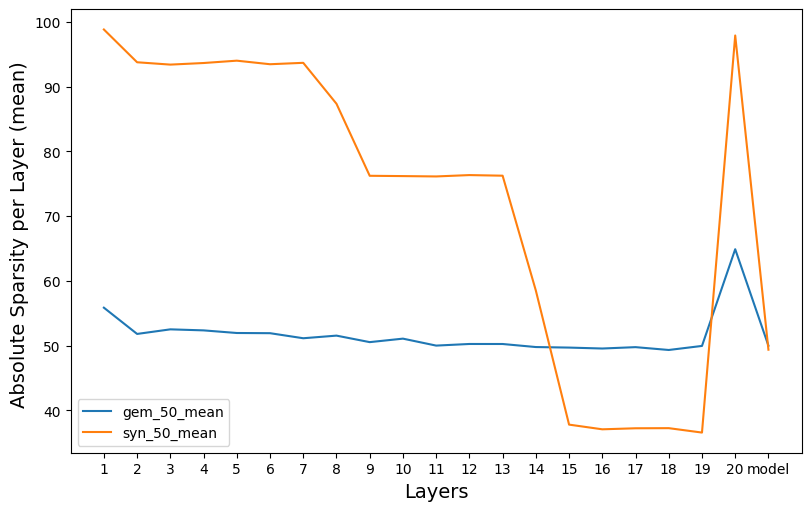

In [49]:
x_axis = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, "model"]

fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')

gem_mean = (np.array(list(sprse_gem_50_21.values())) + 
            np.array(list(sprse_gem_50_42.values())) +
            np.array(list(sprse_gem_50_63.values()))) / 3
ax.plot(x_axis, gem_mean, label='gem_50_mean')


syn_mean = (np.array(list(sprse_syn_50_21.values())) + 
            np.array(list(sprse_syn_50_42.values())) + 
            np.array(list(sprse_syn_50_63.values()))) / 3
ax.plot(x_axis, syn_mean, label='syn_50_mean')


#rnd_mean = (np.array(list(sprse_rnd_50_21.values())) + 
#            np.array(list(sprse_rnd_50_42.values())) + 
#            np.array(list(sprse_rnd_50_63.values()))) / 3
#ax.plot(x_axis, rnd_mean, label='rnd_50_mean')

ax.set_xlabel("Layers", fontsize=14)
ax.set_ylabel("Absolute Sparsity per Layer (mean) ", fontsize=14)

ax.legend()
plt.show()

### Get units

In [19]:
gem_fil_50_21 = get_filters(gem_model_50_21)
gem_fil_50_42 = get_filters(gem_model_50_42)
gem_fil_50_63 = get_filters(gem_model_50_63)

In [50]:
syn_fil_50_21 = get_filters(syn_model_50_21)
syn_fil_50_42 = get_filters(syn_model_50_42)
syn_fil_50_63 = get_filters(syn_model_50_63)

In [21]:
#rnd_fil_50_21 = get_filters(rnd_model_50_21)
#rnd_fil_50_42 = get_filters(rnd_model_50_42)
#rnd_fil_50_63 = get_filters(rnd_model_50_63)

### Define distance measures

In [22]:
# code from Liu et al 2020
# https://github.com/Shiweiliuiiiiiii/Sparse_Topology_Distance/blob/master/sparse_topology_distance.py

def getNormalizedEditDistance(a, b):

    # for two hidden neuron trees, return 1 if they are completely different, 0 if they are exactly the same
    if (len(a) == 0 and len(b) == 0):
        return 0
    intersect, inda, indb = np.intersect1d(a, b, return_indices=True)
    if (intersect.shape[0] > 0):
        edit = np.delete(a, inda).shape[0] + np.delete(b, indb).shape[0]
        normalizedEdit = edit / np.unique(np.concatenate((a, b), axis=0)).shape[0]
    else:
        normalizedEdit = 1
    return normalizedEdit

In [23]:
# code from Holler 2022
# https://github.com/Holleri/code_bachelor_thesis/blob/main/code_Distances/SaSD%20first-layer-first.ipynb

def editDistanceSigns(a,b):
    nums = len(a) - len(np.intersect1d(np.where(b==0), np.where(a==0)))
    same = len(np.intersect1d(np.where(a<0), np.where(b<0))) + len(np.intersect1d(np.where(a>0), np.where(b>0)))
    if nums == 0:
        return 0
    return (nums-same)/nums

In [24]:
def mean_absolute_error_distance(a,b):
    
    a_flat_sort = np.sort(a.flatten())
    b_flat_sort = np.flip(np.sort(b.flatten()))
    
    worst_alignment = sum(abs(a_flat_sort - b_flat_sort))

    dist = sum(abs(a - b).flatten()) / worst_alignment
    
    return dist

### Get all distances between unordered models

In [25]:
fil_1 = gem_fil_50_21
fil_2 = gem_fil_50_42

all_dist_matrices_un = []

for x in range(len(fil_1)):
    new_mat = np.zeros((len(fil_1[x]), len(fil_2[x])), dtype=float)
    
    for i in range(len(fil_1[x])):
        for j in range(len(fil_2[x])):
            dist = 0

            dist = editDistanceSigns(fil_1[x][i].flatten(),fil_2[x][j].flatten())

            new_mat[i][j] = dist
            
    all_dist_matrices_un.append(new_mat)

### Get all distances between ordered models

In [26]:
fil_1 = gem_fil_50_21
fil_2 = order_by_dist(gem_fil_50_21, gem_fil_50_42, editDistanceSigns)

all_dist_matrices_or = []

for x in range(len(fil_1)):
    new_mat = np.zeros((len(fil_1[x]), len(fil_2[x])), dtype=float)
    
    for i in range(len(fil_1[x])):
        for j in range(len(fil_2[x])):
            dist = 0

            dist = editDistanceSigns(fil_1[x][i].flatten(),fil_2[x][j].flatten())

            new_mat[i][j] = dist
            
    all_dist_matrices_or.append(new_mat)

### Plot ordered and unordered distances 

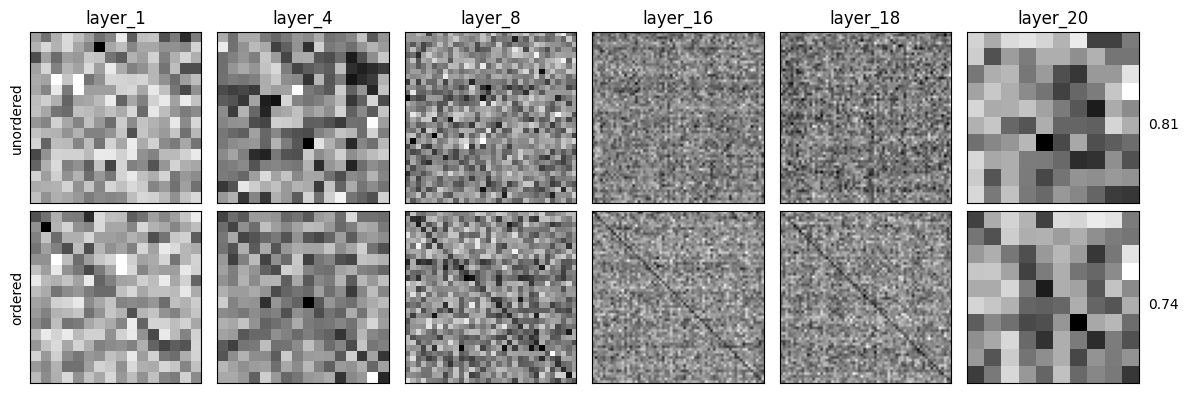

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(12,4))

counter = 0

some_dist_matrices_un = [all_dist_matrices_un[0], all_dist_matrices_un[3], all_dist_matrices_un[7], 
                        all_dist_matrices_un[15], all_dist_matrices_un[17], all_dist_matrices_un[19]]

some_dist_matrices_or = [all_dist_matrices_or[0], all_dist_matrices_or[3], all_dist_matrices_or[7], 
                        all_dist_matrices_or[15], all_dist_matrices_or[17], all_dist_matrices_or[19]]

all_dists = some_dist_matrices_un + some_dist_matrices_or

dist = 0
counter = 0
counter_list = [0,3,7,15,17,19]

for ax in axs.flat:
    if counter == 6:
        dist = 0
        
    img = all_dists[counter]
    ax.imshow(img, cmap = "gray")

    if counter == 0:
        ax.set_title(f"layer_{counter + 1}")
        ax.set_ylabel("unordered")

    if counter < 6:
        ax.set_title(f"layer_{counter_list[counter] + 1}")
    
    if counter == 6:
        ax.set_ylabel("ordered")
        
    dist += sum(all_dists[counter].diagonal()) / (len(all_dists[counter].diagonal()))

    if counter == 5 or counter == 11:
        dist = np.round(dist / 6, 2)

        ax.yaxis.set_label_position("right")
        ax.set_ylabel(f"{dist}", rotation=0, labelpad=18)

    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    counter += 1

plt.tight_layout()
plt.show()

### Compare all models with each other based on mean absolutes error distance

In [28]:
all_model_names =  ["gem_21", "gem_42", "gem_63",
                    "syn_21", "syn_42", "syn_63",
                    "rnd_21", "rnd_42", "rnd_63"]

all_models = [gem_fil_50_21, gem_fil_50_42, gem_fil_50_63,
              syn_fil_50_21, syn_fil_50_42, syn_fil_50_63,
              rnd_fil_50_21, rnd_fil_50_42, rnd_fil_50_63]

all_dist_combinations = []
new_mat_mean = np.zeros((9, 9), dtype=float)

for i in range(len(all_models)):
    for j in range(len(all_models)):
        if i != j:
            combi = all_model_names[i] + all_model_names[j]
            if combi not in all_dist_combinations:
                dist = 0
                ordered_model = order_by_dist(all_models[i], all_models[j], mean_absolute_error_distance, fc = True)

                for layer in range(len(all_models[i])):  
                    dist += mean_absolute_error_distance(all_models[i][layer].flatten(),ordered_model[layer].flatten())
                
                dist = dist / len(all_models[i])
                
                new_mat_mean[i][j] = dist
                new_mat_mean[j][i] = dist
                
                all_dist_combinations.append(all_model_names[i] + all_model_names[j])
                all_dist_combinations.append(all_model_names[j] + all_model_names[i])
 
    

NameError: name 'syn_fil_50_21' is not defined

In [ ]:
fig, ax = plt.subplots()
img = ax.imshow(new_mat_mean)

ax.set_yticks(np.arange(0,9,1))
ax.tick_params(axis="y")
ax.set_yticklabels(all_model_names)

ax.set_xticks(np.arange(0,9,1))
ax.tick_params(axis="x", rotation=90)
ax.set_xticklabels(all_model_names)
ax.set_title("Distances based on Mean Error", fontsize = 14,pad= 30)
fig.colorbar(img)
fig.show()

### Compare all models with each other based on edit distance signs measure

In [ ]:
all_model_names =  ["gem_21", "gem_42", "gem_63",
                    "syn_21", "syn_42", "syn_63",
                    "rnd_21", "rnd_42", "rnd_63"]

all_models = [gem_fil_50_21, gem_fil_50_42, gem_fil_50_63,
              syn_fil_50_21, syn_fil_50_42, syn_fil_50_63,
              rnd_fil_50_21, rnd_fil_50_42, rnd_fil_50_63]

all_dist_combinations = []
new_mat_signs = np.zeros((9, 9), dtype=float)

for i in range(len(all_models)):
    for j in range(len(all_models)):
        if i != j:
            combi = all_model_names[i] + all_model_names[j]
            if combi not in all_dist_combinations:
                dist = 0
                ordered_model = order_by_dist(all_models[i], all_models[j], editDistanceSigns, fc = True)

                for layer in range(len(all_models[i])):  
                    dist += editDistanceSigns(all_models[i][layer].flatten(),ordered_model[layer].flatten())
                
                dist = dist / len(all_models[i])
                
                new_mat_signs[i][j] = dist
                new_mat_signs[j][i] = dist
          
                all_dist_combinations.append(all_model_names[i] + all_model_names[j])
                all_dist_combinations.append(all_model_names[j] + all_model_names[i])
 
    

In [ ]:
fig, ax = plt.subplots()
img = ax.imshow(new_mat_signs)

ax.set_yticks(np.arange(0,9,1))
ax.tick_params(axis="y")
ax.set_yticklabels(all_model_names)

ax.set_xticks(np.arange(0,9,1))
ax.tick_params(axis="x", rotation=90)
ax.set_xticklabels(all_model_names)
fig.colorbar(img)
fig.show()

### Compare all models with each other based on normalized edit distance measure

In [ ]:
all_model_names =  ["gem_21", "gem_42", "gem_63",
                    "syn_21", "syn_42", "syn_63",
                    "rnd_21", "rnd_42", "rnd_63"]

all_models = [gem_fil_50_21, gem_fil_50_42, gem_fil_50_63,
              syn_fil_50_21, syn_fil_50_42, syn_fil_50_63,
              rnd_fil_50_21, rnd_fil_50_42, rnd_fil_50_63]

all_dist_combinations = []
new_mat_edit = np.zeros((9, 9), dtype=float)

for i in range(len(all_models)):
    for j in range(len(all_models)):
        if i != j:
            combi = all_model_names[i] + all_model_names[j]
            if combi not in all_dist_combinations:        
                dist = 0
                ordered_model = order_by_dist(all_models[i], all_models[j], getNormalizedEditDistance, fc = True, nED=True)

                for layer in range(len(all_models[i])):  
                    dist += getNormalizedEditDistance(np.nonzero(all_models[i][layer].flatten())[0],np.nonzero(ordered_model[layer].flatten())[0])
                
                dist = dist / len(all_models[i])
                
                new_mat_edit[i][j] = dist
                new_mat_edit[j][i] = dist
                
                all_dist_combinations.append(all_model_names[i] + all_model_names[j])
                all_dist_combinations.append(all_model_names[j] + all_model_names[i])
 
    

In [ ]:
fig, ax = plt.subplots()
img = ax.imshow(new_mat_edit)

ax.set_yticks(np.arange(0,9,1))
ax.tick_params(axis="y")
ax.set_yticklabels(all_model_names)

ax.set_xticks(np.arange(0,9,1))
ax.tick_params(axis="x", rotation=90)
ax.set_xticklabels(all_model_names)
fig.colorbar(img)
fig.show()

In [33]:
# Find max bipartite matching of between-net correlation matrix
gem_gem_cor = get_correlation(gem_fm_50_21, gem_fm_50_42)
gem_gem_match_max_no_diag = find_max_matching(gem_gem_cor[0])
gem_gem_mat_semi = change_mat(gem_gem_cor[0],gem_gem_match_max_no_diag)

In [36]:
gem_gem_cor = get_correlation(gem_fm_50_21, gem_fm_50_42)
gem_gem_semi_no_diag = find_semi_matching(gem_gem_cor[0])
gem_gem_mat_semi = change_mat(gem_gem_cor[0],gem_gem_semi_no_diag)

In [ ]:
gem_gem_match_max_no_diag

In [ ]:
test = get_correlation(gem_fm_50_21, gem_gem_mat_semi)

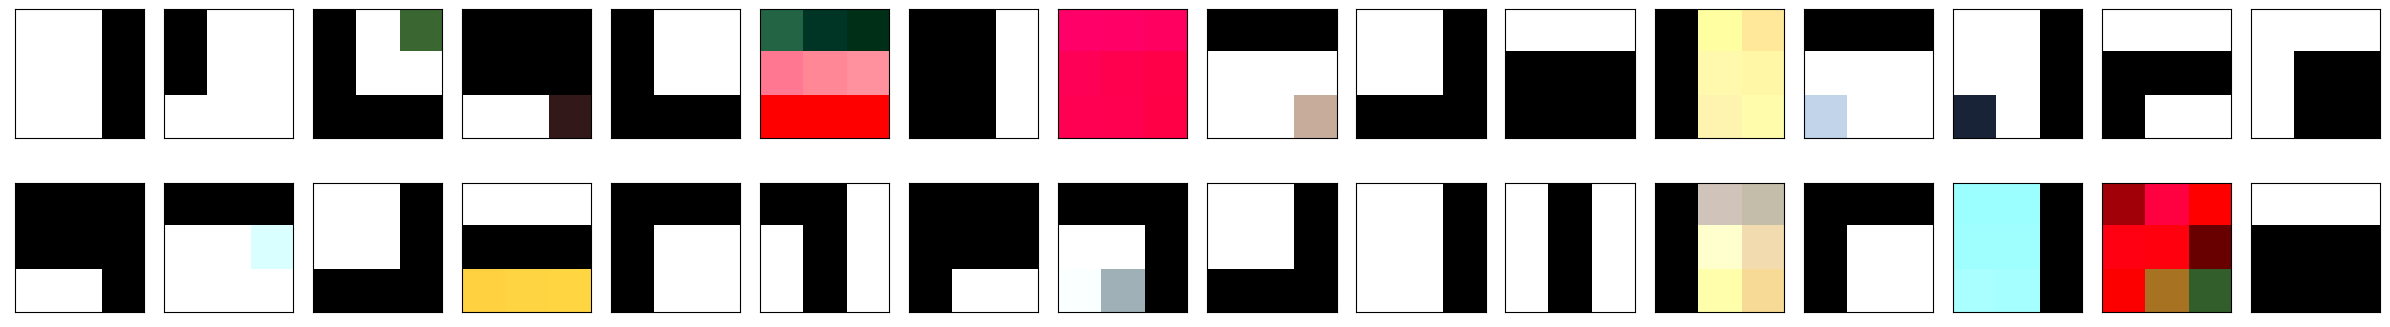

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=16, figsize=(24,4))

for idx, ax in enumerate(axs.flat):
    if idx < 16:
        filters = gem_fil_50_21
    else:
        filters = gem_fil_50_42
        idx = idx - 16
        idx = gem_gem_match_max_no_diag[idx]
    
    k_idx, img = get_image_patch(images_cifar10, 0, idx, filters, "last")    
    
    y = k_idx[0]
    x = k_idx[1]
    
    ax.imshow(img[:][y-1:y+2 , x-1:x+2])
        
    
    #ax.set_title(f"gem_feature_layer_1_unit_{idx + 1}")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

# Semantic analysis

### Load data set

In [30]:
batch_of_images_cifar10 = get_images_cifar10(batch_size = 600)

Files already downloaded and verified
Files already downloaded and verified


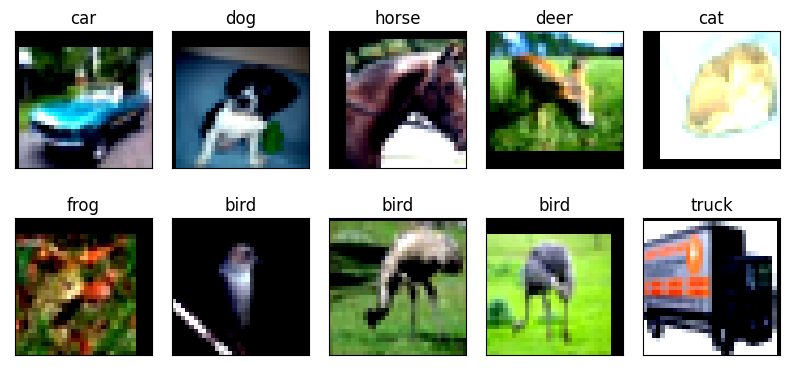

In [31]:
images_cifar10, _ = batch_of_images_cifar10.get_new_images(output = True)
batch_of_images_cifar10.display((8,4), unique = 10)

### Get activations over data from units

In [32]:
gem_fm_50_21 = get_activation_series(images_cifar10, gem_fil_50_21, "last")
gem_fm_50_42 = get_activation_series(images_cifar10, gem_fil_50_42, "last")
gem_fm_50_63 = get_activation_series(images_cifar10, gem_fil_50_63, "last")


#syn_fm_50_21 = get_activation_series(images_mnist, syn_fil_50_21, "all")
#syn_fm_50_42 = get_activation_series(images_mnist, syn_fil_50_42, "all")
#syn_fm_50_63 = get_activation_series(images_mnist, syn_fil_50_63, "all")


#rnd_fm_50_21 = get_activation_series(images_mnist, rnd_fil_50_21, "all")
#rnd_fm_50_42 = get_activation_series(images_mnist, rnd_fil_50_42, "all")
#rnd_fm_50_63 = get_activation_series(images_mnist, rnd_fil_50_63, "all")

### Get correlations of activations

In [ ]:
gem_gem_21_42_cor = get_correlation(gem_fm_50_21, gem_fm_50_42)
gem_gem_21_63_cor = get_correlation(gem_fm_50_21, gem_fm_50_63)
gem_gem_42_63_cor = get_correlation(gem_fm_50_42, gem_fm_50_63)


#syn_syn_21_42_cor = get_correlation(syn_fm_50_21, syn_fm_50_42)
#syn_syn_21_63_cor = get_correlation(syn_fm_50_21, syn_fm_50_63)
#syn_syn_42_63_cor = get_correlation(syn_fm_50_42, syn_fm_50_63)


#rnd_rnd_21_42_cor = get_correlation(rnd_fm_50_21, rnd_fm_50_42)
#rnd_rnd_21_63_cor = get_correlation(rnd_fm_50_21, rnd_fm_50_63)
#rnd_rnd_42_63_cor = get_correlation(rnd_fm_50_42, rnd_fm_50_63)

### Plot correlations for gem miner

In [ ]:
gem_cor = [gem_gem_21_42_cor, gem_gem_21_63_cor, gem_gem_42_63_cor]
gem_cor_names = ["gem_gem_21_42_cor", "gem_gem_21_63_cor", "gem_gem_42_63_cor"]
counter_list = [0,3,7,15,17,19]

for i in range(3):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(12,8))
    counter = 0
    dist = 0
    for ax in axs.flat:
        img = gem_cor[i][counter_list[counter]]
        ax.imshow(img, cmap = "rainbow")
        
        if i == 0:
            ax.set_title(f"layer_{counter_list[counter] + 1}")
        
        if counter == 0:
            ax.set_ylabel(f"{gem_cor_names[i]}")
            
        dist += sum(gem_cor[i][counter].diagonal()) / (len(gem_cor[i][counter].diagonal()))
        
        if counter == 5:
            dist = np.round(dist / 6, 2)
            
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{dist}", rotation=0, labelpad=18)

        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        counter += 1

    plt.tight_layout()
    plt.show()

### Order gem miner models for better comparrison

In [ ]:
all_gem_gem_max_matched_matrices = []
all_gem_gem_semi_matched_matrices = []

for i in range(3):
    max_matched_matrices = []
    semi_matched_matrices = []
    for j in range(20):
        
        gem_gem_match_semi_no_diag = find_semi_matching(gem_cor[i][j])
        gem_gem_mat_semi = change_mat(gem_cor[i][j],gem_gem_match_semi_no_diag)

        semi_matched_matrices.append(gem_gem_mat_semi)

        gem_gem_match_max_no_diag = find_max_matching(gem_cor[i][j])
        gem_gem_mat_max = change_mat(gem_cor[i][j],gem_gem_match_max_no_diag)

        max_matched_matrices.append(gem_gem_mat_max)
    
    all_gem_gem_max_matched_matrices.append(max_matched_matrices)
    all_gem_gem_semi_matched_matrices.append(semi_matched_matrices)

In [ ]:
counter_list = [0,3,7,15,17,19]
for i in range(3):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(14,10))
    counter = 0
    dist = 0
    for ax in axs.flat:
        img = all_gem_gem_max_matched_matrices[i][counter_list[counter]]
        ax.imshow(img, cmap = "rainbow")
        
        if i == 0:
            ax.set_title(f"layer_{counter_list[counter] + 1}")
        
        if counter == 0:
            ax.set_ylabel(f"{gem_cor_names[i]}")
        
        dist += sum(all_gem_gem_max_matched_matrices[i][counter].diagonal()) / (len(all_gem_gem_max_matched_matrices[i][counter].diagonal()))
        
        if counter == 5:
            dist = np.round(dist / 6, 2)
            
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{dist}", rotation=0, labelpad=18)
        
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        counter += 1

    plt.tight_layout()
    plt.show()

### Plot semi and max matches for gem miner

In [ ]:
for i in range(3):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(24,4))
    counter = 0
    dist = 0
    for ax in axs.flat:
        
        
        xcor = gem_cor[i][counter]
        match = find_max_matching(gem_cor[i][counter])

        match_vals = xcor[np.arange(xcor.shape[0]),match]
        diag_order = (-xcor.max(1)).argsort()

        if counter == 5:
            x_axis = np.arange(0,10,1)
        else:
            x_axis = np.arange(0,100,1)
        
        ax.plot(x_axis, xcor[diag_order,:].max(1), 'o-', color=(.21/.84,.84/.84,.57/.84), lw=2, ms=10)
        ax.plot(x_axis, match_vals[diag_order], 'o-', color=(0,.45,.25), lw=2, ms=5)

        counter += 1
        
    plt.tight_layout()
    plt.show()

### Order synflow models for better comparrison

In [ ]:
all_syn_syn_max_matched_matrices = []
all_syn_syn_semi_matched_matrices = []

syn_cor = [syn_syn_21_42_cor, syn_syn_21_63_cor, syn_syn_42_63_cor]
syn_cor_names = ["syn_syn_21_42_cor", "syn_syn_21_63_cor", "syn_syn_42_63_cor"]


for i in range(3):
    max_matched_matrices = []
    semi_matched_matrices = []
    
    for j in range(6):
        
        syn_syn_match_semi_no_diag = find_semi_matching(syn_cor[i][j])
        syn_syn_mat_semi = change_mat(syn_cor[i][j],syn_syn_match_semi_no_diag)

        semi_matched_matrices.append(syn_syn_mat_semi)

        syn_syn_match_max_no_diag = find_max_matching(syn_cor[i][j])
        syn_syn_mat_max = change_mat(syn_cor[i][j],syn_syn_match_max_no_diag)

        max_matched_matrices.append(syn_syn_mat_max)
    
    all_syn_syn_max_matched_matrices.append(max_matched_matrices)
    all_syn_syn_semi_matched_matrices.append(semi_matched_matrices)

In [ ]:
for i in range(3):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(14,10))
    counter = 0
    dist = 0
    for ax in axs.flat:
        img = all_syn_syn_max_matched_matrices[i][counter]
        ax.imshow(img, cmap = "rainbow")
        
        if i == 0:
            ax.set_title(f"layer_{counter + 1}")
        
        if counter == 0:
            ax.set_ylabel(f"{syn_cor_names[i]}")
        
        dist += sum(all_syn_syn_max_matched_matrices[i][counter].diagonal()) / (len(all_syn_syn_max_matched_matrices[i][counter].diagonal()))
        
        if counter == 5:
            dist = np.round(dist / 6, 2)
            
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{dist}", rotation=0, labelpad=18)
        
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        counter += 1

    plt.tight_layout()
    plt.show()

### Plot semi and max matches for synflow

In [ ]:
for i in range(3):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(24,4))
    counter = 0
    dist = 0
    for ax in axs.flat:
        
        xcor = syn_cor[i][counter]
        match = find_max_matching(syn_cor[i][counter])

        match_vals = xcor[np.arange(xcor.shape[0]),match]
        diag_order = (-xcor.max(1)).argsort()

        if counter == 5:
            x_axis = np.arange(0,10,1)
        else:
            x_axis = np.arange(0,100,1)
        
        ax.plot(x_axis, xcor[diag_order,:].max(1), 'o-', color=(.21/.84,.84/.84,.57/.84), lw=2, ms=10)
        ax.plot(x_axis, match_vals[diag_order], 'o-', color=(0,.45,.25), lw=2, ms=5)

        counter += 1
        
    plt.tight_layout()
    plt.show()

### Order randomly pruned models for better comparrison

In [ ]:
all_rnd_rnd_max_matched_matrices = []
all_rnd_rnd_semi_matched_matrices = []

rnd_cor = [rnd_rnd_21_42_cor, rnd_rnd_21_63_cor, rnd_rnd_42_63_cor]
rnd_cor_names = ["rnd_rnd_21_42_cor", "rnd_rnd_21_63_cor", "rnd_rnd_42_63_cor"]


for i in range(3):
    max_matched_matrices = []
    semi_matched_matrices = []
    
    for j in range(6):
        
        rnd_rnd_match_semi_no_diag = find_semi_matching(rnd_cor[i][j])
        rnd_rnd_mat_semi = change_mat(rnd_cor[i][j],rnd_rnd_match_semi_no_diag)

        semi_matched_matrices.append(rnd_rnd_mat_semi)

        rnd_rnd_match_max_no_diag = find_max_matching(rnd_cor[i][j])
        rnd_rnd_mat_max = change_mat(rnd_cor[i][j],rnd_rnd_match_max_no_diag)

        max_matched_matrices.append(rnd_rnd_mat_max)
    
    all_rnd_rnd_max_matched_matrices.append(max_matched_matrices)
    all_rnd_rnd_semi_matched_matrices.append(semi_matched_matrices)

In [ ]:
for i in range(3):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(14,10))
    counter = 0
    dist = 0
    for ax in axs.flat:
        img = all_rnd_rnd_max_matched_matrices[i][counter]
        ax.imshow(img, cmap = "rainbow")
        
        if i == 0:
            ax.set_title(f"layer_{counter + 1}")
        
        if counter == 0:
            ax.set_ylabel(f"{rnd_cor_names[i]}")
        
        dist += sum(all_rnd_rnd_max_matched_matrices[i][counter].diagonal()) / (len(all_rnd_rnd_max_matched_matrices[i][counter].diagonal()))
        
        if counter == 5:
            dist = np.round(dist / 6, 2)
            
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{dist}", rotation=0, labelpad=18)
        
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        counter += 1

    plt.tight_layout()
    plt.show()

### Plot semi and max matches for randomly pruned models

In [ ]:
for i in range(3):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(24,4))
    counter = 0
    dist = 0
    for ax in axs.flat:
        
        xcor = rnd_cor[i][counter]
        match = find_max_matching(rnd_cor[i][counter])

        match_vals = xcor[np.arange(xcor.shape[0]),match]
        diag_order = (-xcor.max(1)).argsort()

        if counter == 5:
            x_axis = np.arange(0,10,1)
        else:
            x_axis = np.arange(0,100,1)
        
        ax.plot(x_axis, xcor[diag_order,:].max(1), 'o-', color=(.21/.84,.84/.84,.57/.84), lw=2, ms=10)
        ax.plot(x_axis, match_vals[diag_order], 'o-', color=(0,.45,.25), lw=2, ms=5)

        counter += 1
        
    plt.tight_layout()
    plt.show()

# Compare differently pruned models

## Get correlations of different feature maps 

In [ ]:
gem_syn_21_21_cor = get_correlation(gem_fm_50_21, syn_fm_50_21)
gem_syn_21_42_cor = get_correlation(gem_fm_50_21, syn_fm_50_42)
gem_syn_21_63_cor = get_correlation(gem_fm_50_21, syn_fm_50_63)

gem_syn_42_21_cor = get_correlation(gem_fm_50_42, syn_fm_50_21)
gem_syn_42_42_cor = get_correlation(gem_fm_50_42, syn_fm_50_42)
gem_syn_42_63_cor = get_correlation(gem_fm_50_42, syn_fm_50_63)

gem_syn_63_21_cor = get_correlation(gem_fm_50_63, syn_fm_50_21)
gem_syn_63_42_cor = get_correlation(gem_fm_50_63, syn_fm_50_42)
gem_syn_63_63_cor = get_correlation(gem_fm_50_63, syn_fm_50_63)



gem_rnd_21_21_cor = get_correlation(gem_fm_50_21, rnd_fm_50_21)
gem_rnd_21_42_cor = get_correlation(gem_fm_50_21, rnd_fm_50_42)
gem_rnd_21_63_cor = get_correlation(gem_fm_50_21, rnd_fm_50_63)

gem_rnd_42_21_cor = get_correlation(gem_fm_50_42, rnd_fm_50_21)
gem_rnd_42_42_cor = get_correlation(gem_fm_50_42, rnd_fm_50_42)
gem_rnd_42_63_cor = get_correlation(gem_fm_50_42, rnd_fm_50_63)

gem_rnd_63_21_cor = get_correlation(gem_fm_50_63, rnd_fm_50_21)
gem_rnd_63_42_cor = get_correlation(gem_fm_50_63, rnd_fm_50_42)
gem_rnd_63_63_cor = get_correlation(gem_fm_50_63, rnd_fm_50_63)



syn_rnd_21_21_cor = get_correlation(syn_fm_50_21, rnd_fm_50_21)
syn_rnd_21_42_cor = get_correlation(syn_fm_50_21, rnd_fm_50_42)
syn_rnd_21_63_cor = get_correlation(syn_fm_50_21, rnd_fm_50_63)

syn_rnd_42_21_cor = get_correlation(syn_fm_50_42, rnd_fm_50_21)
syn_rnd_42_42_cor = get_correlation(syn_fm_50_42, rnd_fm_50_42)
syn_rnd_42_63_cor = get_correlation(syn_fm_50_42, rnd_fm_50_63)

syn_rnd_63_21_cor = get_correlation(syn_fm_50_63, rnd_fm_50_21)
syn_rnd_63_42_cor = get_correlation(syn_fm_50_63, rnd_fm_50_42)
syn_rnd_63_63_cor = get_correlation(syn_fm_50_63, rnd_fm_50_63)

## Compare feature maps of gem-miner and synflow pruned models

In [ ]:
gem_syn_model_names =  ["gem_syn_21_21_cor", "gem_syn_21_42_cor", "gem_syn_21_63_cor",
                        "gem_syn_42_21_cor", "gem_syn_42_42_cor", "gem_syn_42_63_cor",
                        "gem_syn_63_21_cor", "gem_syn_63_42_cor", "gem_syn_63_63_cor"]


gem_syn_models = [gem_syn_21_21_cor, gem_syn_21_42_cor, gem_syn_21_63_cor,
                  gem_syn_42_21_cor, gem_syn_42_42_cor, gem_syn_42_63_cor,
                  gem_syn_63_21_cor, gem_syn_63_42_cor, gem_syn_63_63_cor]
              

gem_syn_max_matched_matrices = []

for model in gem_syn_models:
    
    gem_syn_matrices = []
    
    for i in range(6):
                
        match_max_no_diag = find_max_matching(model[i])
        mat_max = change_mat(model[i], match_max_no_diag)
    
        gem_syn_matrices.append(mat_max)
    
    gem_syn_max_matched_matrices.append(gem_syn_matrices)
 

In [ ]:
for i in range(9):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(14,10))
    counter = 0
    dist = 0
    for ax in axs.flat:
        img = gem_syn_max_matched_matrices[i][counter]
        ax.imshow(img, cmap = "rainbow")
        
        if i == 0:
            ax.set_title(f"layer_{counter + 1}")
        
        if counter == 0:
            ax.set_ylabel(f"{gem_syn_model_names[i]}")
        
        dist += sum(gem_syn_max_matched_matrices[i][counter].diagonal()) / (len(gem_syn_max_matched_matrices[i][counter].diagonal()))
        
        if counter == 5:
            dist = np.round(dist / 6, 2)
            
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{dist}", rotation=0, labelpad=18)
        
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        counter += 1

    plt.tight_layout()
    plt.show()

## Compare feature maps of gem-miner and randomly pruned models

In [ ]:
gem_rnd_model_names =  ["gem_rnd_21_21_cor", "gem_rnd_21_42_cor", "gem_rnd_21_63_cor",
                        "gem_rnd_42_21_cor", "gem_rnd_42_42_cor", "gem_rnd_42_63_cor",
                        "gem_rnd_63_21_cor", "gem_rnd_63_42_cor", "gem_rnd_63_63_cor"]


gem_rnd_models = [gem_rnd_21_21_cor, gem_rnd_21_42_cor, gem_rnd_21_63_cor,
                  gem_rnd_42_21_cor, gem_rnd_42_42_cor, gem_rnd_42_63_cor,
                  gem_rnd_63_21_cor, gem_rnd_63_42_cor, gem_rnd_63_63_cor]
              

gem_rnd_max_matched_matrices = []

for model in gem_rnd_models:
    
    gem_rnd_matrices = []
    
    for i in range(6):
                
        match_max_no_diag = find_max_matching(model[i])
        mat_max = change_mat(model[i], match_max_no_diag)
    
        gem_rnd_matrices.append(mat_max)
    
    gem_rnd_max_matched_matrices.append(gem_rnd_matrices)
 

In [ ]:
for i in range(9):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(14,10))
    counter = 0
    dist = 0
    for ax in axs.flat:
        img = gem_rnd_max_matched_matrices[i][counter]
        ax.imshow(img, cmap = "rainbow")
        
        if i == 0:
            ax.set_title(f"layer_{counter + 1}")
        
        if counter == 0:
            ax.set_ylabel(f"{gem_rnd_model_names[i]}")
        
        dist += sum(gem_rnd_max_matched_matrices[i][counter].diagonal()) / (len(gem_rnd_max_matched_matrices[i][counter].diagonal()))
        
        if counter == 5:
            dist = np.round(dist / 6, 2)
            
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{dist}", rotation=0, labelpad=18)
        
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        counter += 1

    plt.tight_layout()
    plt.show()

## Compare feature maps of synflow and randomly pruned models

In [ ]:
syn_rnd_model_names =  ["syn_rnd_21_21_cor", "syn_rnd_21_42_cor", "syn_rnd_21_63_cor",
                        "syn_rnd_42_21_cor", "syn_rnd_42_42_cor", "syn_rnd_42_63_cor",
                        "syn_rnd_63_21_cor", "syn_rnd_63_42_cor", "syn_rnd_63_63_cor"]


syn_rnd_models = [syn_rnd_21_21_cor, syn_rnd_21_42_cor, syn_rnd_21_63_cor,
                  syn_rnd_42_21_cor, syn_rnd_42_42_cor, syn_rnd_42_63_cor,
                  syn_rnd_63_21_cor, syn_rnd_63_42_cor, syn_rnd_63_63_cor]
              

syn_rnd_max_matched_matrices = []

for model in syn_rnd_models:
    
    syn_rnd_matrices = []
    
    for i in range(6):
                
        match_max_no_diag = find_max_matching(model[i])
        mat_max = change_mat(model[i], match_max_no_diag)
    
        syn_rnd_matrices.append(mat_max)
    
    syn_rnd_max_matched_matrices.append(syn_rnd_matrices)
 

In [ ]:
for i in range(9):
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(14,10))
    counter = 0
    dist = 0
    for ax in axs.flat:
        img = syn_rnd_max_matched_matrices[i][counter]
        ax.imshow(img, cmap = "rainbow")
        
        if i == 0:
            ax.set_title(f"layer_{counter + 1}")
        
        if counter == 0:
            ax.set_ylabel(f"{syn_rnd_model_names[i]}")
        
        dist += sum(syn_rnd_max_matched_matrices[i][counter].diagonal()) / (len(syn_rnd_max_matched_matrices[i][counter].diagonal()))
        
        if counter == 5:
            dist = np.round(dist / 6, 2)
            
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f"{dist}", rotation=0, labelpad=18)
        
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        counter += 1

    plt.tight_layout()
    plt.show()